In [1]:
# !pip install xarray --upgrade

In [2]:
from datacube import Datacube
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from scipy import stats, signal
from datacube.utils.geometry import assign_crs
import sys
sys.path.append('../dea-notebooks/Scripts')
from dea_datahandling import load_ard
from dea_plotting import display_map
from dea_dask import create_local_dask_cluster
from dea_temporal_statistics import fast_completion, smooth

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:44677 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


## Load Data

In [4]:
lat, lon = -32.0449, 145.3608
buffer = 0.05
time = ('2013', '2019')

In [5]:
dc = Datacube(app='whatevrr')

query = {'lon': (lon - buffer, lon + buffer),
         'lat': (lat - buffer, lat + buffer),
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "average"}}

In [6]:
# display_map((lon - buffer, lon + buffer),(lat - buffer, lat + buffer))

In [7]:
ds = load_ard(dc=dc, 
              dask_chunks={'x':2000, 'y':2000, 'time':-1},
              min_gooddata=0.2,
              products=['ga_ls8c_ard_3'],
              **query)
# print(ds)

../dea-notebooks/Scripts/dea_datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 194 out of 269 time steps with at least 20.0% good quality pixels
Applying pixel quality/cloud mask
Returning 194 time steps as a dask array


## Calculate std anomalies

Alternative approach: take a 12-month rolling average, then detrend the data. Signal detrend requires removing all NaNs.

    data = data.rolling(time=52, center=True).mean()[26:-26,...]\
    mean = data.mean(axis=0)
    data = xr.DataArray(signal.detrend(data, axis=0), dims=data.dims, coords=data.coords) + mean


In [8]:
ndvi = (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + ds.nbart_red)

In [9]:
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time="1W").interpolate("linear")
ndvi = ndvi.rolling(time=3, min_periods=1).mean().dropna("time")

In [10]:
climatology_mean = ndvi.groupby("time.week").mean("time")
climatology_std = ndvi.groupby("time.week").std("time")


In [11]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ndvi.groupby("time.week"),
    climatology_mean,
    climatology_std,
    output_dtypes=[ndvi.dtype],
    dask="allowed"
)

In [12]:
stand_anomalies = stand_anomalies.compute()

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


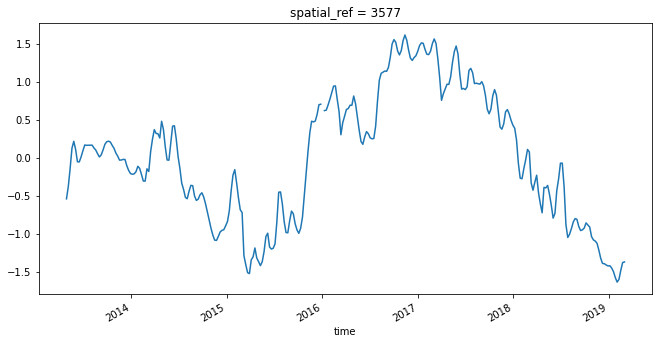

In [13]:
stand_anomalies.mean(['x','y']).plot(figsize=(11,5));

## Testing autocorrelation

Initially testing on the 1D example, once we understand we can explore the 3D example

In [14]:
zonal_mean = stand_anomalies.mean(['x','y'])
df = zonal_mean.drop('spatial_ref').drop('week').to_dataframe(name='stand_anomalies').dropna()

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Check for Autocorrelation (ie correlation between adjacent timesteps)

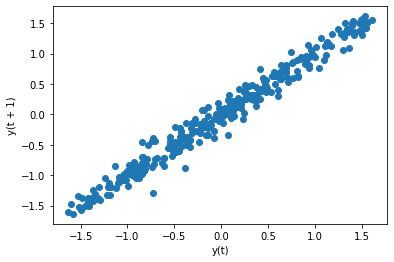

In [15]:
lag_plot(df)

#### Pearsons coefficient

In [16]:
values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.988119
t+1  0.988119  1.000000


## Check for stationarity

If the p-value on the ADF stat is <0.05, then time-series is stationary

The KPSS statistic checks for trend stationarity. If the p-value on the KPSS stat is > 0.05, the time-series has a trend

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df.values, autolag='AIC')
print(f'ADF Statistic: {round(result[0],3)}')
print(f'p-value: {round(result[1],3)}')

# KPSS Test
result = kpss(df.values, regression='c')
print('\nKPSS Statistic: %f' % round(result[0],3))
print('p-value: %f' % round(result[1],3))


ADF Statistic: -0.959
p-value: 0.768

KPSS Statistic: 0.265000
p-value: 0.100000


/env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## Check 'forecast-ability' 

Using the 'Sample Entropy' we can determine how susceptible our time-series is to forecasting.  A low entropy means means more forecastable.

In [18]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))


In [19]:
print(SampEn(df.values, m=2, r=0.2*np.std(df.values))) 

0.49057869409848825


### Make a forecast

predicted=-1.253195, expected=-1.391594
predicted=-1.498386, expected=-1.395498
predicted=-1.377318, expected=-1.411677
predicted=-1.368257, expected=-1.424383
predicted=-1.447097, expected=-1.421949
predicted=-1.384828, expected=-1.451969
predicted=-1.345066, expected=-1.499714
predicted=-1.487465, expected=-1.578459
predicted=-1.786568, expected=-1.637063
predicted=-1.624799, expected=-1.600348
predicted=-1.576210, expected=-1.480694
predicted=-1.454568, expected=-1.379676
predicted=-1.419986, expected=-1.371672
Test RMSE: 0.093


Text(0, 0.5, 'NDVI Std Anomaly')

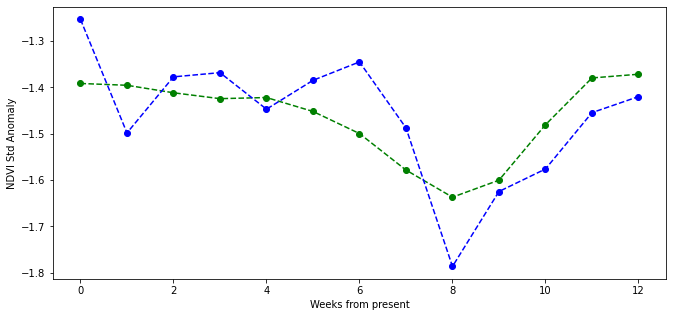

In [20]:
# create and evaluate an updated autoregressive model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt


# split dataset
X = df.values
train, test = X[1:len(X)-13], X[len(X)-13:]

# train autoregression
window = 100
model = AutoReg(train, lags=100)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]

predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
fig=plt.figure(figsize=(11,5))
plt.plot(test, color='green', linestyle='dashed', marker='o')
plt.plot(predictions, color='blue', linestyle='dashed', marker='o')
plt.xlabel('Weeks from present')
plt.ylabel('NDVI Std Anomaly')

## Attempt forecast on 3D Array

Vectorized ufunc works but is very slow



In [39]:
%%time
def xr_autoregress(da, test_length, window, lags):
    #dropna conveneiently with pandas
    da =  da[~np.isnan(da)]
    # split dataset
    train, test = da[1:len(da)-test_length], da[len(da)-test_length:]
    # train autoregression
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs) 
    
    return np.array(predictions).flatten()

predict = xr.apply_ufunc(xr_autoregress,
                      stand_anomalies.chunk({'x':100,'y':100, 'time':-1}),#.isel(x=range(0,100),y=range(0,100)), #
                      kwargs={'test_length':4,'window':100,'lags':100},
                      input_core_dims=[['time']],
                      output_core_dims=[['predictions']], 
                      output_sizes=({'predictions':4}),
                      exclude_dims=set(('time',)),
                      vectorize=True,
                      dask="parallelized",
                      output_dtypes=[stand_anomalies.dtype]).compute()

print(predict)

In [32]:
predict.plot(col='predictions', col_wrap=4, cmap='BrBG', vmin=-2.0, vmax=2.0);

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
predict.mean(['x', 'y']).plot(color='blue',
                                  linestyle='dashed',
                                  marker='o',
                                  ax=ax)


In [35]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
stand_anomalies.isel(time=range(-5, -1)).mean(['x',
                                                'y']).plot(color='blue',
                                                           linestyle='dashed',
                                                           marker='o', ax=ax);

### Try with Numba to speed up


In [41]:
import dask
import distributed
dask.config.set({'distributed.scheduler.allowed-failures': 50}) 

In [48]:
%%time
from numba import float64, guvectorize
from statsmodels.tsa.ar_model import AutoReg

@guvectorize("(float64[:], float64[:])", "(n) -> ()", forceobj=True)
def xr_autoregress_gufunc(da, out):
    test_length=4
    lags=100
    window=100
    #dropnas
    print(da)
    da =  da[~np.isnan(da)]
    # split dataset
    train, test = da[1:len(da)-test_length], da[len(da)-test_length:]
    # train autoregression
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs) 
    
    out[:] =  np.array(predictions).flatten()
    
predict = xr.apply_ufunc(xr_autoregress_gufunc,
                      stand_anomalies.chunk({'time':-1}),
                      input_core_dims=[['time']],
                      output_core_dims=[['predictions']], 
                      output_sizes=({'predictions':4}),
                      exclude_dims=set(('time',)),
                      dask="parallelized",
                      output_dtypes=[stand_anomalies.dtype])

predict

CPU times: user 1.58 s, sys: 1.05 ms, total: 1.58 s
Wall time: 1.54 s


<xarray.DataArray (y: 404, x: 350, predictions: 4)>
dask.array<xr_autoregress_gufunc, shape=(404, 350, 4), dtype=float64, chunksize=(404, 350, 4), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -3.552e+06 -3.552e+06 ... -3.564e+06 -3.564e+06
  * x            (x) float64 1.243e+06 1.243e+06 ... 1.254e+06 1.254e+06
Dimensions without coordinates: predictions

In [49]:
predict = predict.compute()

In [ ]:
# stand_anomalies = stand_anomalies.drop('spatial_ref')
# template = stand_anomalies.transpose("y", "x", "time").chunk({'time':-1})
# stand_anomalies = stand_anomalies.chunk({'time':-1}).map_blocks(
#                             smooth,
#                             template=template
#                         )

In [ ]:
# quarter= {'JFM': [1,2,3],
#            'FMA': [2,3,4],
#            'MAM': [3,4,5],
#            'AMJ': [4,5,6],
#            'MJJ': [5,6,7],
#            'JJA': [6,7,8],
#            'JAS': [7,8,9],
#            'ASO': [8,9,10],
#            'SON': [9,10,11],
#            'OND': [10,11,12],
#            'NDJ': [11,12,1],
#            'DJF': [12,1,2],
#                       }

# def ndvi_climatology(ndvi, stat='mean'):
    
#     ndvi_var = []
#     for q in quarter:
        
#         ix=ndvi['time.month'].isin(quarter[q])
        
#         if stat=='std':
#             ndvi_clim=ndvi.where(ix, drop = True).std(dim='time')   
#         if stat=='mean':
#             ndvi_clim=ndvi.where(ix, drop = True).mean(dim='time') 
        
#         ndvi_clim=ndvi_clim.to_array(name=q).drop('variable').squeeze()
#         ndvi_var.append(ndvi_clim)

#     q_clim = xr.merge(ndvi_var)   
    
#     #assign back attributes
#     crs = ndvi.geobox.crs
#     q_clim = assign_crs(q_clim, str(crs))

#     return q_clim

# mean = ndvi_climatology(ndvi,stat='mean').compute()
# std = ndvi_climatology(ndvi,stat='std').compute()